In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Explore preprocessed features

## Installation and import of the needed libraries


In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import and configuration setup


In [4]:
# python modules
import os
import pickle

# 3rd party modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.pipeline import make_pipeline

# user modules
from utils import util_data

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [6]:
pd.set_option("max_colwidth", 800)

## Explore the dataset

In [62]:
df = pd.read_csv("data/processed/gsm.csv", sep=",", index_col=0)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of nan values: {df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")
df.head(3)

Number of rows: 1911
Number of nan values: 0
Number of duplicated rows: 0


,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,is_waterproof,oem_model,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.3,1,0,1,0,1,1,4G,...,1,Google Pixel 4 XL,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.7,1,0,1,0,1,1,4G,...,1,Google Pixel 4,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.0,1,0,1,1,1,1,4G,...,0,Google Pixel 3a XL,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0


### Split in train-test set

In [8]:
upper_clip = input("Clip price at upper bound? (y/n): ").lower() == "y"
price = df.misc_price.clip(upper=1500).copy() if upper_clip else df.misc_price.copy()
compute_log = input("Compute log of price? (y/n): ").lower() == "y"
if compute_log:
    price = price.apply(np.log)

std_scaler = StandardScaler()
std_price = std_scaler.fit_transform(price.values.reshape(-1, 1))
mean_price, scale_price = std_scaler.mean_, std_scaler.scale_
if compute_log:
    mean_price = np.exp(mean_price)
    # scale_price = np.exp(scale_price)

print(f"Mean of standardized price: {mean_price}")
print(f"Scale of standardized price: {scale_price}")

Mean of standardized price: [227.64274039]
Scale of standardized price: [0.56908089]


Price distribution

The distribution is right skewed, but we can see that the log transformation makes it more normally distributed. However, this transformation is only needed because we want to compute bins for the price in order to perform a stratified split of the dataset.

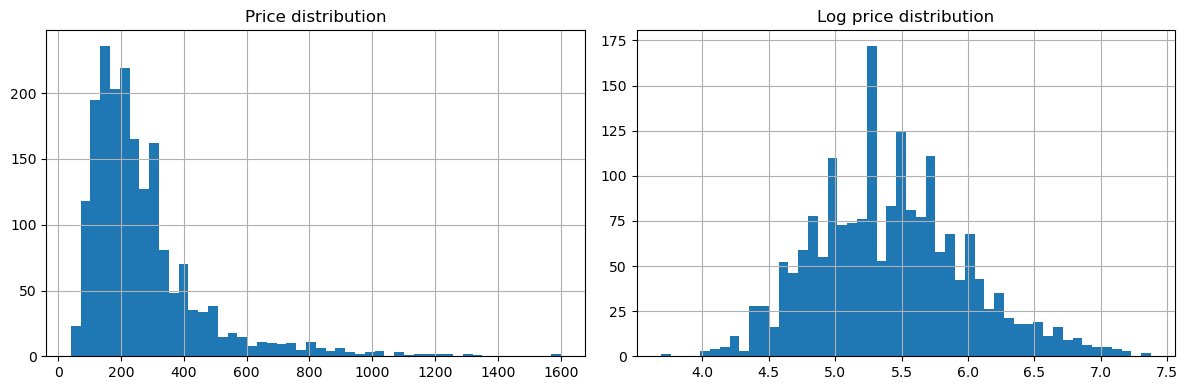

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df.misc_price.hist(bins=50, ax=axs[0])
axs[0].set_title("Price distribution")
df.misc_price.apply(np.log).hist(bins=50, ax=axs[1])
axs[1].set_title("Log price distribution")
fig.tight_layout()

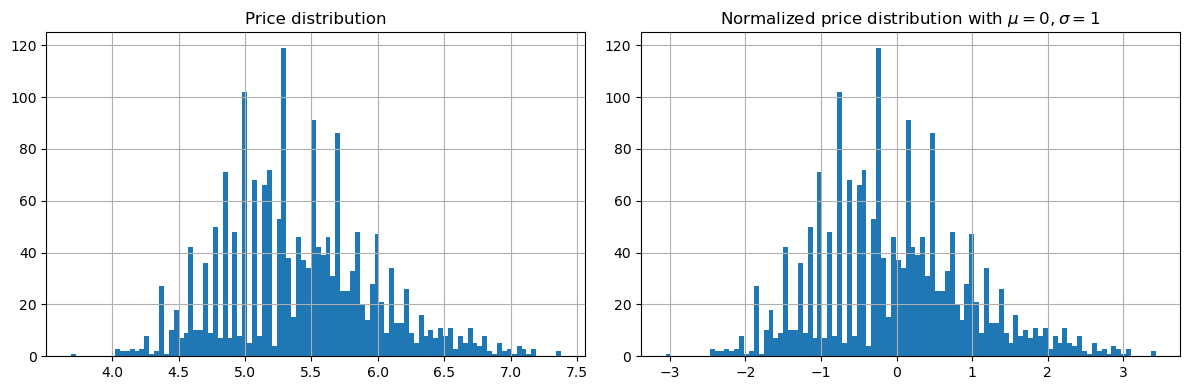

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
faxs = axs.ravel()
price.hist(bins=100, ax=faxs[0])
faxs[0].set_title("Price distribution")
pd.Series(std_price.flatten()).hist(bins=100, ax=faxs[1])
faxs[1].set_title(r"Normalized price distribution with $\mu=0, \sigma=1$")
fig.tight_layout()

Compute bins

The bins are computed using the "fd" method of the [numpy histogram function](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html), which uses the Freedman-Diaconis rule. To avoid having empty bins or bins with only one sample, we clip the lower bound of the first bin to 55, instead of 40. As noticed in the previous plot, we apply the log transformation to the price before computing the bins.

In [13]:
# class LabelEncoder(FunctionTransformer):
#     def __init__(self, bins="doane", **kwargs):
#         self.bins = bins
#         super().__init__(self.compute_label_encoding, kw_args={"bins": bins}, **kwargs)

#     def compute_label_encoding(self, x, bins):
#         _, bin_edges = np.histogram(x, bins=bins)
#         self.bin_edges_ = [bin_edges]
#         bin_edges[-1] = bin_edges[-1] + 1e-6
#         return np.digitize(x, bin_edges, right=False) - 1

clip_fun = util_data.ClipEncoder(lower=55, upper=None, clip=True, validate=False, check_inverse=False)
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp)
label_enc = util_data.LabelEncoder(bins="fd", validate=False, check_inverse=False)
# label_enc = KBinsDiscretizer(n_bins=10, encode="ordinal", subsample=None, strategy="uniform")

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)
label_pipeline.set_output(transform="pandas")
label_cat = label_pipeline.fit_transform(df[["misc_price"]]).misc_price

# get the frequency of each bin
label_cat_freq = label_cat.value_counts().sort_index()

# convert bin edges without the logarithm
bin_edges = np.exp(label_pipeline[2].bin_edges_[0])
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f} | {label_cat_freq[i] if i in label_cat_freq else 0}")

Bin 0: 55.00 - 62.04 | 8
Bin 1: 62.04 - 69.97 | 8
Bin 2: 69.97 - 78.92 | 12
Bin 3: 78.92 - 89.02 | 38
Bin 4: 89.02 - 100.40 | 75
Bin 5: 100.40 - 113.25 | 56
Bin 6: 113.25 - 127.73 | 70
Bin 7: 127.73 - 144.07 | 124
Bin 8: 144.07 - 162.50 | 181
Bin 9: 162.50 - 183.29 | 148
Bin 10: 183.29 - 206.73 | 178
Bin 11: 206.73 - 233.18 | 130
Bin 12: 233.18 - 263.01 | 169
Bin 13: 263.01 - 296.65 | 118
Bin 14: 296.65 - 334.59 | 165
Bin 15: 334.59 - 377.39 | 84
Bin 16: 377.39 - 425.67 | 96
Bin 17: 425.67 - 480.12 | 64
Bin 18: 480.12 - 541.54 | 45
Bin 19: 541.54 - 610.81 | 34
Bin 20: 610.81 - 688.94 | 26
Bin 21: 688.94 - 777.07 | 25
Bin 22: 777.07 - 876.47 | 18
Bin 23: 876.47 - 988.58 | 15
Bin 24: 988.58 - 1115.04 | 10
Bin 25: 1115.04 - 1257.67 | 9
Bin 26: 1257.67 - 1418.54 | 3
Bin 27: 1418.54 - 1600.00 | 2


c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


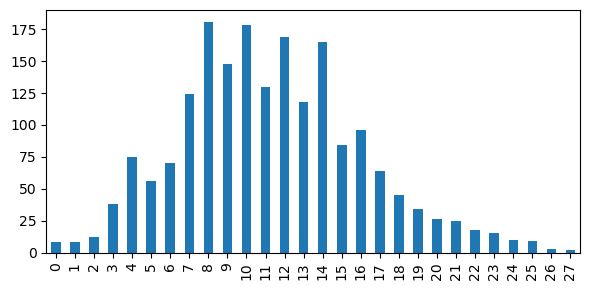

In [14]:
# plot the frequency of each bin
label_cat_freq.plot.bar(figsize=(6, 3))
plt.tight_layout()

Split in training and validation sets

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=rng, shuffle=True, stratify=label_cat)
print(f"Number of rows in train set: {df_train.shape[0]}")
print(f"Number of rows in test set: {df_test.shape[0]}")

Number of rows in train set: 1528
Number of rows in test set: 383


In [67]:
# save train and test sets
df_train.to_csv("data/processed/gsm_train.csv", index=True)
df_test.to_csv("data/processed/gsm_test.csv", index=True)

#### Launch announced

Except for the 2020, the dataset is balanced, describing that the number of smartphones released is essentially the same every year. The 2020 shows few samples because the data aren't complete for this year.

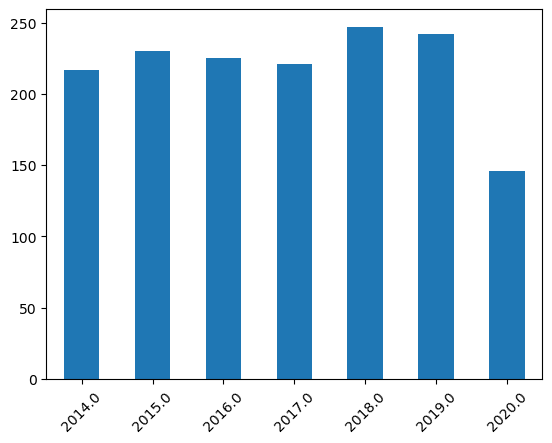

In [68]:
df_train.launch_announced.value_counts().sort_index().plot.bar(rot=45)
plt.show()

#### Misc price

There are many outliers which depicts the presence of some expensive devices. These devices are not removed because even this kind of devices are relevant for the task, but the labels distribution for the classification tasks will be surely unbalanced.

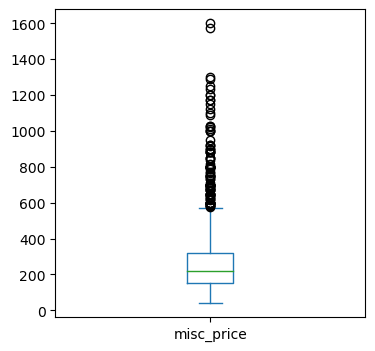

In [69]:
df_train.misc_price.plot.box(whis=1.5, figsize=(4,4))
plt.show()

Distribution of the price in different years.

There is a clear trend of the price increasing over the years. This is probably due to the fact that the smartphones are becoming more and more powerful and the price is increasing accordingly, but also because the price of the components is increasing or for [shortages of components](https://en.wikipedia.org/wiki/2020%E2%80%93present_global_chip_shortage).

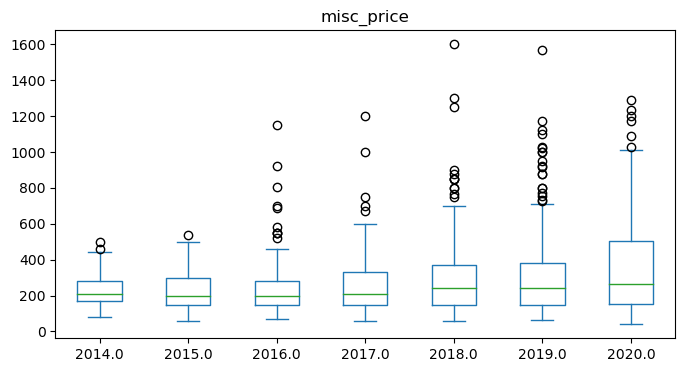

In [70]:
# show boxplot of misc_price for distinct launch_announced
df_train.plot.box(by="launch_announced", column="misc_price", figsize=(8, 4))
plt.show()

#### Display resolution

The display resolution size is a feature currently represented as continuous, but it can be discretized in [known categories](https://en.wikipedia.org/wiki/Comparison_of_high-definition_smartphone_displays) in order to be used for classification tasks. The categories are qHD (540x960), HD (768x1024), FHD (1080x1920), QHD (1440x2560).

In [71]:
size_unique: np.ndarray = df_train[["display_width", "display_height"]].apply(lambda x: f"{x[0]}|{x[1]}", axis=1).unique()
size_df = pd.DataFrame(list(map(lambda x: x.split("|"), size_unique)), columns=["display_width", "display_height"]).astype(float)
size_df.head()

,display_width,display_height
0,720.0,1520.0
1,1080.0,2340.0
2,1080.0,2160.0
3,720.0,1280.0
4,1440.0,2560.0


In [72]:
resolutions = {"qHD": [540, 960], "HD": [768, 1024], "FHD": [1080, 1920], "QHD": [1440, 2560]}
resolutions_df = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

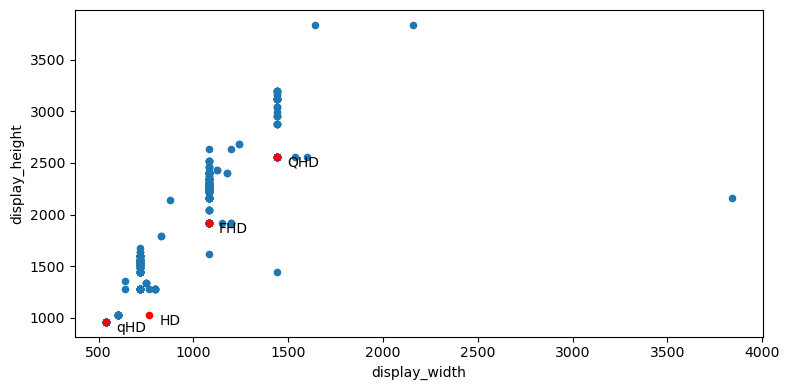

In [73]:
fig, axs = plt.subplots(1, figsize=(8, 4))
df_train.plot(kind="scatter", x="display_width", y="display_height", ax=axs)
resolutions_df.plot(kind="scatter", x="display_width", y="display_height", ax=axs, color="red")
for name, pp in resolutions.items():
    axs.annotate(name, pp, xytext=(10, -10), textcoords="offset pixels")
plt.tight_layout()


#### Continuous features

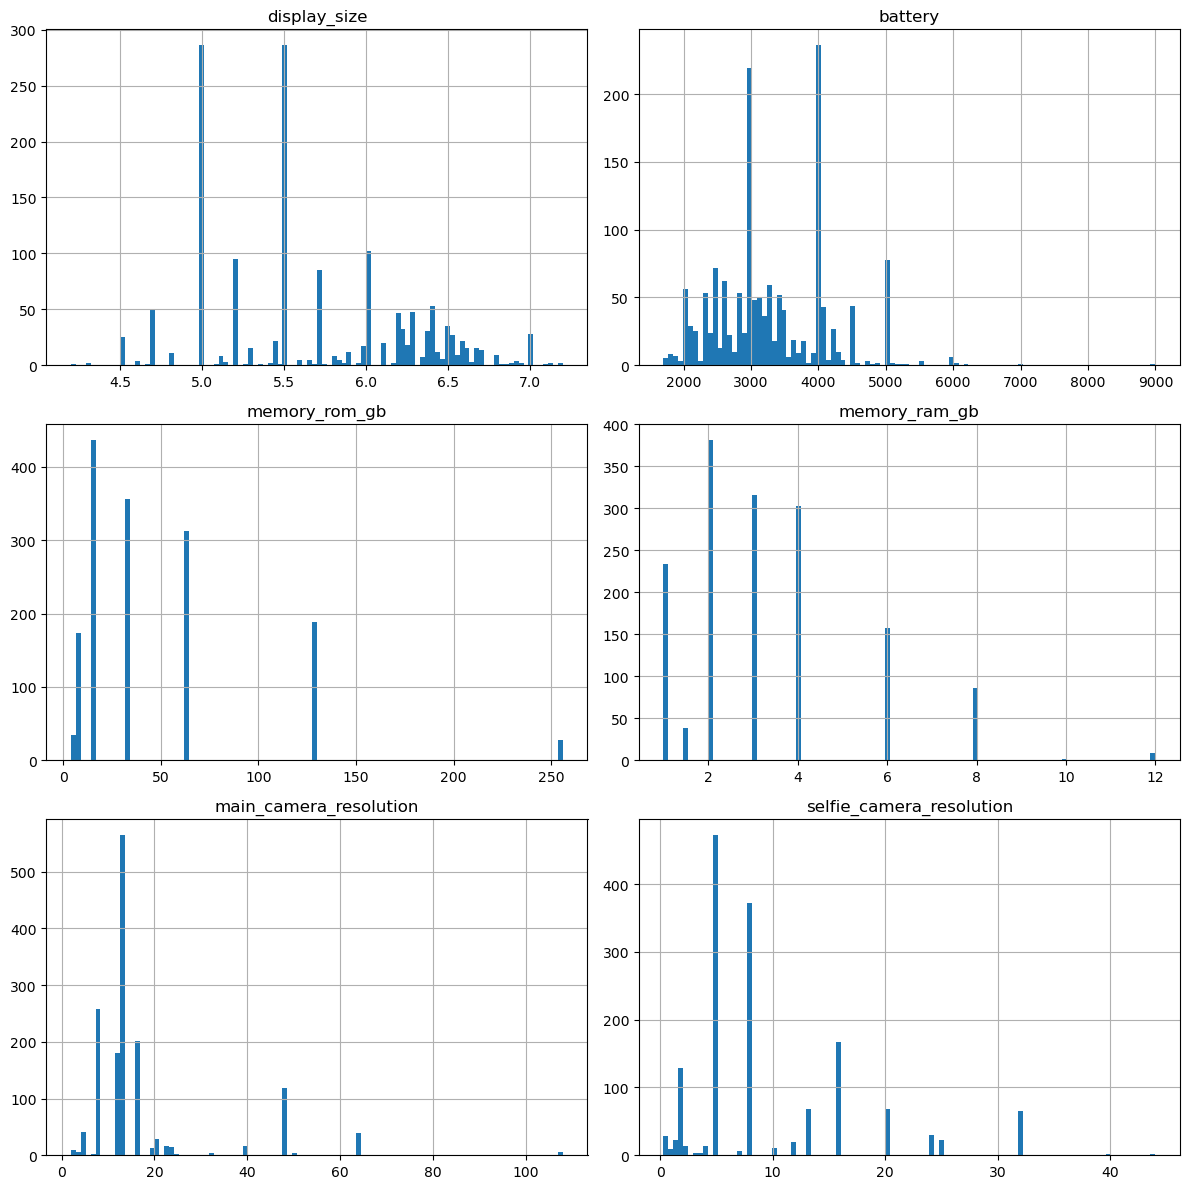

In [74]:
num_features = ["display_size", "battery", "memory_rom_gb", "memory_ram_gb", "main_camera_resolution", "selfie_camera_resolution"]
n_cols, n_rows = 2, round(len(num_features) / 2)
df_train[num_features].hist(bins=100, figsize=(6 * n_cols, 4 * n_rows), layout=(n_rows, n_cols), sharex=False, sharey=False)
plt.tight_layout()

### Plot of numerical feature correlations

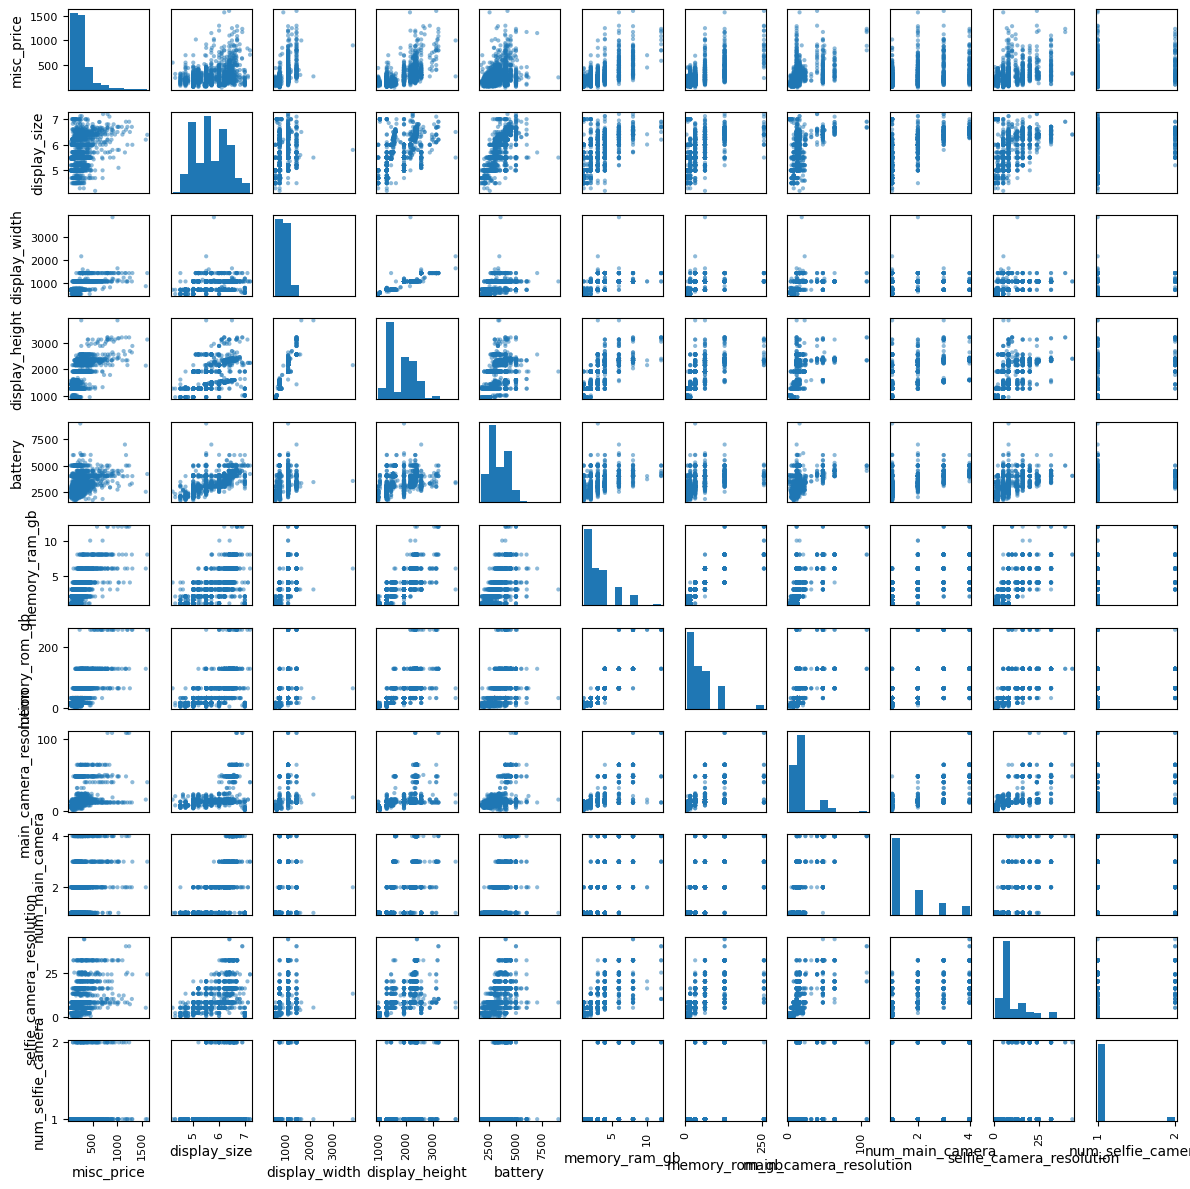

In [75]:
from pandas.plotting import scatter_matrix


attributes = [
    "misc_price",
    "display_size",
    "display_width",
    "display_height",
    "battery",
    "memory_ram_gb",
    "memory_rom_gb",
    "main_camera_resolution",
    "num_main_camera",
    "selfie_camera_resolution",
    "num_selfie_camera",
]
scatter_matrix(df_train[attributes], figsize=(12, 12))
plt.tight_layout()


### Correlation between data

In [76]:
df_train.corr(numeric_only=True)["misc_price"].sort_values(ascending=False)

misc_price                  1.000000
memory_ram_gb               0.673402
memory_rom_gb               0.663328
display_height              0.622258
display_width               0.563831
has_oled_display            0.540462
has_wireless_charging       0.513071
has_wlan_5ghz               0.468785
has_nfc                     0.454356
selfie_camera_resolution    0.419745
is_waterproof               0.418694
main_camera_resolution      0.405625
has_stereo_speakers         0.394014
num_main_camera             0.372514
display_size                0.345383
battery                     0.289179
num_selfie_camera           0.255134
launch_announced            0.230018
has_memory_card_slot       -0.489450
has_3.5mm_jack             -0.564116
Name: misc_price, dtype: float64

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.


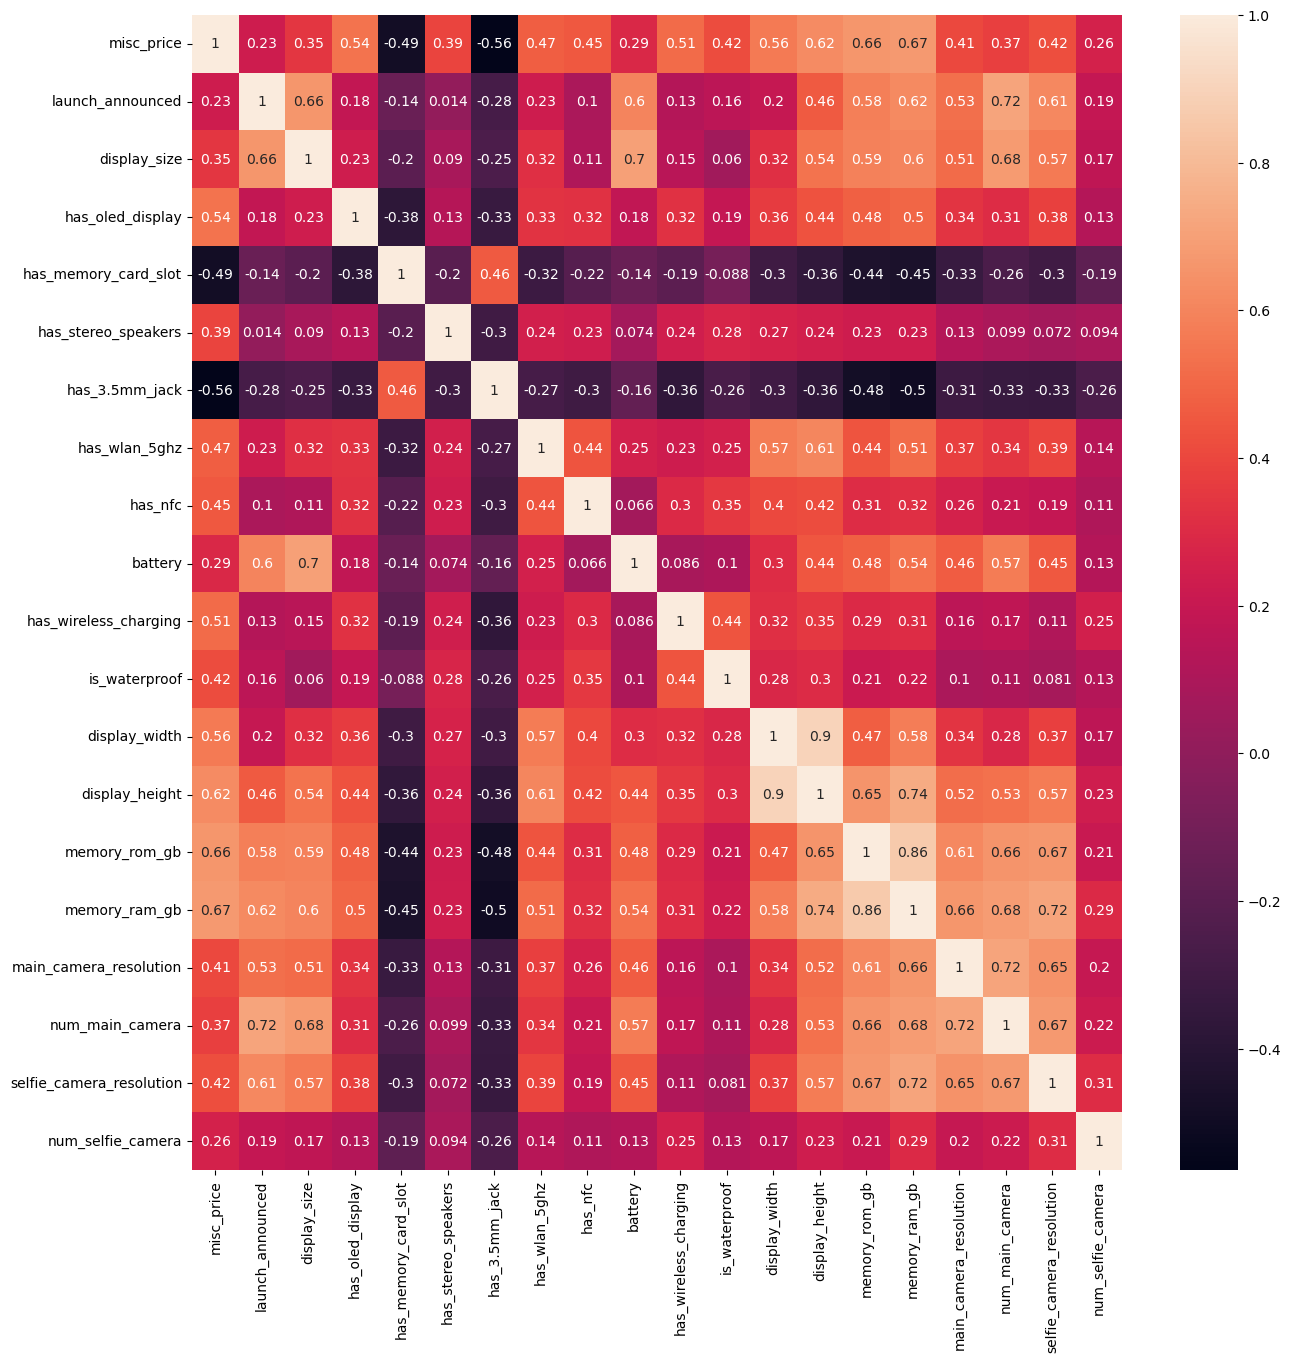

In [77]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(numeric_only=True), annot=True)
plt.show()


In [78]:
df_train.describe()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
count,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.00000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000
mean,271.127275,2016.890707,5.678233,0.248691,0.838351,0.150524,0.912958,0.537958,0.388743,3317.142016,0.062173,0.13089,926.085079,1776.791885,46.565445,3.258181,17.335471,1.613220,9.573298,1.047775
std,187.629746,1.916520,0.622876,0.432396,0.368249,0.357701,0.281989,0.498720,0.487624,839.565305,0.241548,0.33739,246.926537,509.825871,46.990639,1.983048,14.060464,0.927077,7.620682,0.213359
min,40.000000,2014.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1700.000000,0.000000,0.00000,540.000000,960.000000,4.000000,1.000000,2.000000,1.000000,0.300000,1.000000
25%,150.000000,2015.000000,5.100000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2726.500000,0.000000,0.00000,720.000000,1280.000000,16.000000,2.000000,12.000000,1.000000,5.000000,1.000000
50%,220.000000,2017.000000,5.500000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3100.000000,0.000000,0.00000,1080.000000,1920.000000,32.000000,3.000000,13.000000,1.000000,8.000000,1.000000
75%,320.000000,2019.000000,6.220000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4000.000000,0.000000,0.00000,1080.000000,2244.000000,64.000000,4.000000,16.000000,2.000000,13.000000,1.000000
max,1600.000000,2020.000000,7.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.00000,3840.000000,3840.000000,256.000000,12.000000,108.000000,4.000000,44.000000,2.000000


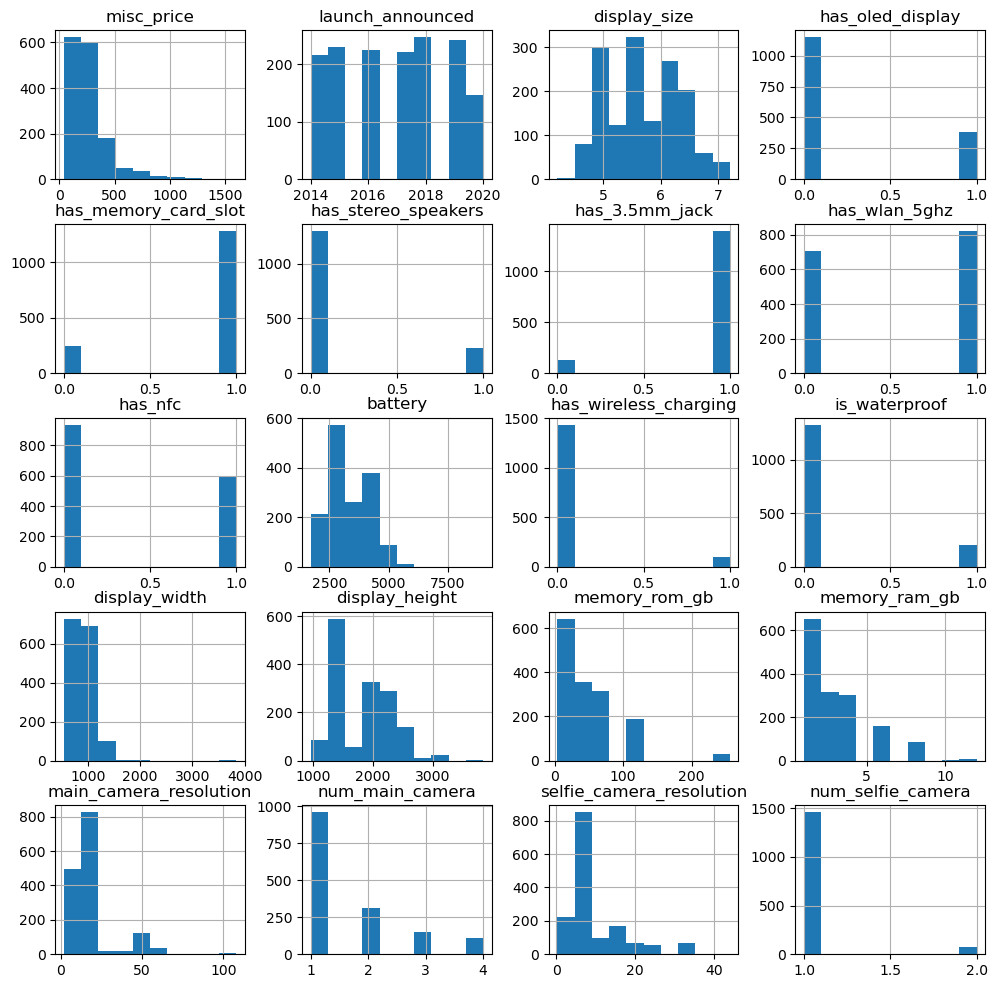

In [79]:
df_train.hist(figsize=(12, 12))
plt.show()

## Transform features

In [24]:
df_train = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
df_test = pd.read_csv("data/processed/gsm_test.csv", index_col=0)

### Features

#### misc_price

In [25]:
label_columns = ["misc_price"]
label_pipeline = make_pipeline(
    util_data.LabelEncoder(
        bins=[df_train.misc_price.min(), 215, 420, df_train.misc_price.max()],
        validate=False,
        check_inverse=False,
        feature_names_out="one-to-one",
    )
)
label_transformer = ("label", label_pipeline, label_columns)

#### Continuous features 

display_size, battery, memory_ram_gb, memory_rom_gb

In [26]:
cont_columns = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb"]
cont_pipeline = make_pipeline(
    FunctionTransformer(np.log1p, validate=False, check_inverse=False, inverse_func=np.expm1, feature_names_out="one-to-one"),
    RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)
)
cont_transformer = ("continuous", cont_pipeline, cont_columns)

#### Camera features (with round)

main_camera_resolution, selfie_camera_resolution

In [40]:
camera_columns = ["main_camera_resolution", "selfie_camera_resolution"]
camera_pipeline = make_pipeline(
    FunctionTransformer(np.ceil, validate=False, inverse_func=np.round, check_inverse=False, feature_names_out="one-to-one"),
    FunctionTransformer(np.log1p, validate=False, check_inverse=False, inverse_func=np.expm1, feature_names_out="one-to-one"),
    RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)
)
camera_transformer = ("camera", camera_pipeline, camera_columns)

#### Display feature

display_width, display_height

In [28]:
resolutions ={"qHD": [540, 960], "HD": [768, 1024], "FHD": [1080, 1920], "QHD": [1440, 2560]}
df_res = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

display_columns = ["display_width", "display_height"]
display_pipeline = make_pipeline(
    util_data.DisplayEncoder(resolutions=df_res),
    OrdinalEncoder(categories=[list(resolutions.keys())])
)
display_transformer = ("display", display_pipeline, display_columns)

#### Ordinal feature

network_technology, num_main_camera, num_selfie_camera

In [29]:
ordinal_columns = ["network_technology", "num_main_camera"]
ordinal_categories = [["3G", "4G", "5G"], [1., 2., 3., 4.]]
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=ordinal_categories))
ordinal_transformer = ("ordinal", ordinal_pipeline, ordinal_columns)

#### Boolean feature

has_oled_display, has_memory_card_slot, has_stereo_speakers, has_3.5mm_jack, has_wlan_5ghz, has_nfc, has_wireless_charging, is_waterproof

In [30]:
id_columns = ["has_oled_display", "has_memory_card_slot", "has_stereo_speakers", 
              "has_3.5mm_jack", "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]
id_pipeline = make_pipeline(FunctionTransformer(validate=False, check_inverse=False, feature_names_out="one-to-one"))
id_transformer = ("id", id_pipeline, id_columns)

#### Pipeline for the transformation of the features.

In [41]:
pipeline = ColumnTransformer([
    label_transformer,
    cont_transformer,
    camera_transformer,
    display_transformer,
    ordinal_transformer,
    id_transformer],
    verbose_feature_names_out=False
)
pipeline.set_output(transform="pandas")
pipeline.fit(df_train)

c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


ColumnTransformer(transformers=[('label',
                                 Pipeline(steps=[('labelencoder',
                                                  LabelEncoder(bins=[40.0, 215,
                                                                     420,
                                                                     1600.0]))]),
                                 ['misc_price']),
                                ('continuous',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>)),
                                                 ('robustscaler',
                                                  RobustScaler(unit_variance=...
                                                                              4.0]]))]),
                                 ['network_technology', 'num_main_camera']),
                                ('id',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      feature_names_out='one-to-one'))]),
                                 ['has_oled_display', 'has_memory_card_slot',
                                  'has_stereo_speakers', 'has_3.5mm_jack',
                                  'has_wlan_5ghz', 'has_nfc',
                                  'has_wireless_charging', 'is_waterproof'])],
                  verbose_feature_names_out=False)

Save the pipeline for inverse transformation.

In [42]:
pickle.dump(pipeline, open("config/pipeline.pkl", "wb"))

### Transform of train and test set

In [43]:
train_preprocess = pipeline.transform(df_train)
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows before preprocessing: {train_preprocess.shape[0]}")

# keep only one instance between duplicates equal in all features
train_preprocess = train_preprocess.drop_duplicates(ignore_index=False, keep="first")
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows after removing duplicates: {train_preprocess.shape[0]}")

# remove all duplicated with different label
X_columns = train_preprocess.columns.drop("misc_price").to_list()
train_preprocess = train_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=False)
assert isinstance(train_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {train_preprocess.shape[0]}")
display(train_preprocess.head())

Number of rows before preprocessing: 1528
Number of rows after removing duplicates: 1523
Number of rows after preprocessing: 1521


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
1501,0,0.840703,0.923432,-0.759706,-0.667155,0.000000,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,0
1193,1,0.928887,0.427140,0.589274,1.371239,0.976324,1.012555,2.0,1.0,1.0,0,1,0,1,1,0,0,0
477,1,0.242524,1.009706,-0.759706,-0.667155,0.976324,0.000000,2.0,1.0,1.0,0,1,0,1,0,0,0,0
264,0,0.840703,1.682568,0.000000,0.000000,-0.372656,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,1
847,1,-1.336879,0.000000,-0.759706,-0.667155,-2.221779,-1.749096,1.0,1.0,0.0,0,1,1,1,1,1,0,1


In [44]:
bin_edges = pipeline.transformers_[0][1][0].bin_edges_[0]
# bin_edges = np.exp(pipeline.transformers_[0][1][2].bin_edges_.item())
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f}")
util_data.count_frequency_labels(train_preprocess.misc_price).sort_index()

Bin 0: 40.00 - 215.00
Bin 1: 215.00 - 420.00
Bin 2: 420.00 - 1600.00


,Frequency,Count
0,49.11%,747
1,36.88%,561
2,14.00%,213


Preprocess test set.

In [45]:
test_preprocess = pipeline.transform(df_test)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows before preprocessing: {test_preprocess.shape[0]}")
# keep only one instance between duplicates equal in all features
test_preprocess = test_preprocess.drop_duplicates(ignore_index=False, keep="first")
assert isinstance(test_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = test_preprocess.columns.drop("misc_price").to_list()
test_preprocess = test_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=False)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {test_preprocess.shape[0]}")
test_preprocess.head()

Number of rows before preprocessing: 383
Number of rows after preprocessing: 383


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,1,0.928887,0.940857,0.589274,0.681825,3.112871,0.703440,2.0,1.0,1.0,0,1,0,1,1,1,0,1
1861,1,0.000000,-0.115404,0.000000,0.000000,0.976324,0.000000,3.0,1.0,0.0,1,1,1,1,1,1,0,0
1339,1,0.593062,0.427140,0.589274,0.000000,0.976324,1.012555,2.0,1.0,0.0,1,1,0,1,1,1,0,1
664,0,0.695297,-0.092018,0.000000,0.681825,0.000000,0.000000,2.0,1.0,0.0,0,1,0,1,0,0,0,0
918,1,-0.640555,-0.871517,0.000000,0.000000,0.000000,0.000000,2.0,1.0,0.0,0,1,0,1,1,0,0,0


In [46]:
# save train_preprocess
train_preprocess.to_csv("data/model/gsm_train.csv", index=True)
test_preprocess.to_csv("data/model/gsm_test.csv", index=True)

## Exploration

In [21]:
df = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
train_preprocess = pd.read_csv("data/model/gsm_train.csv", index_col=0)
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

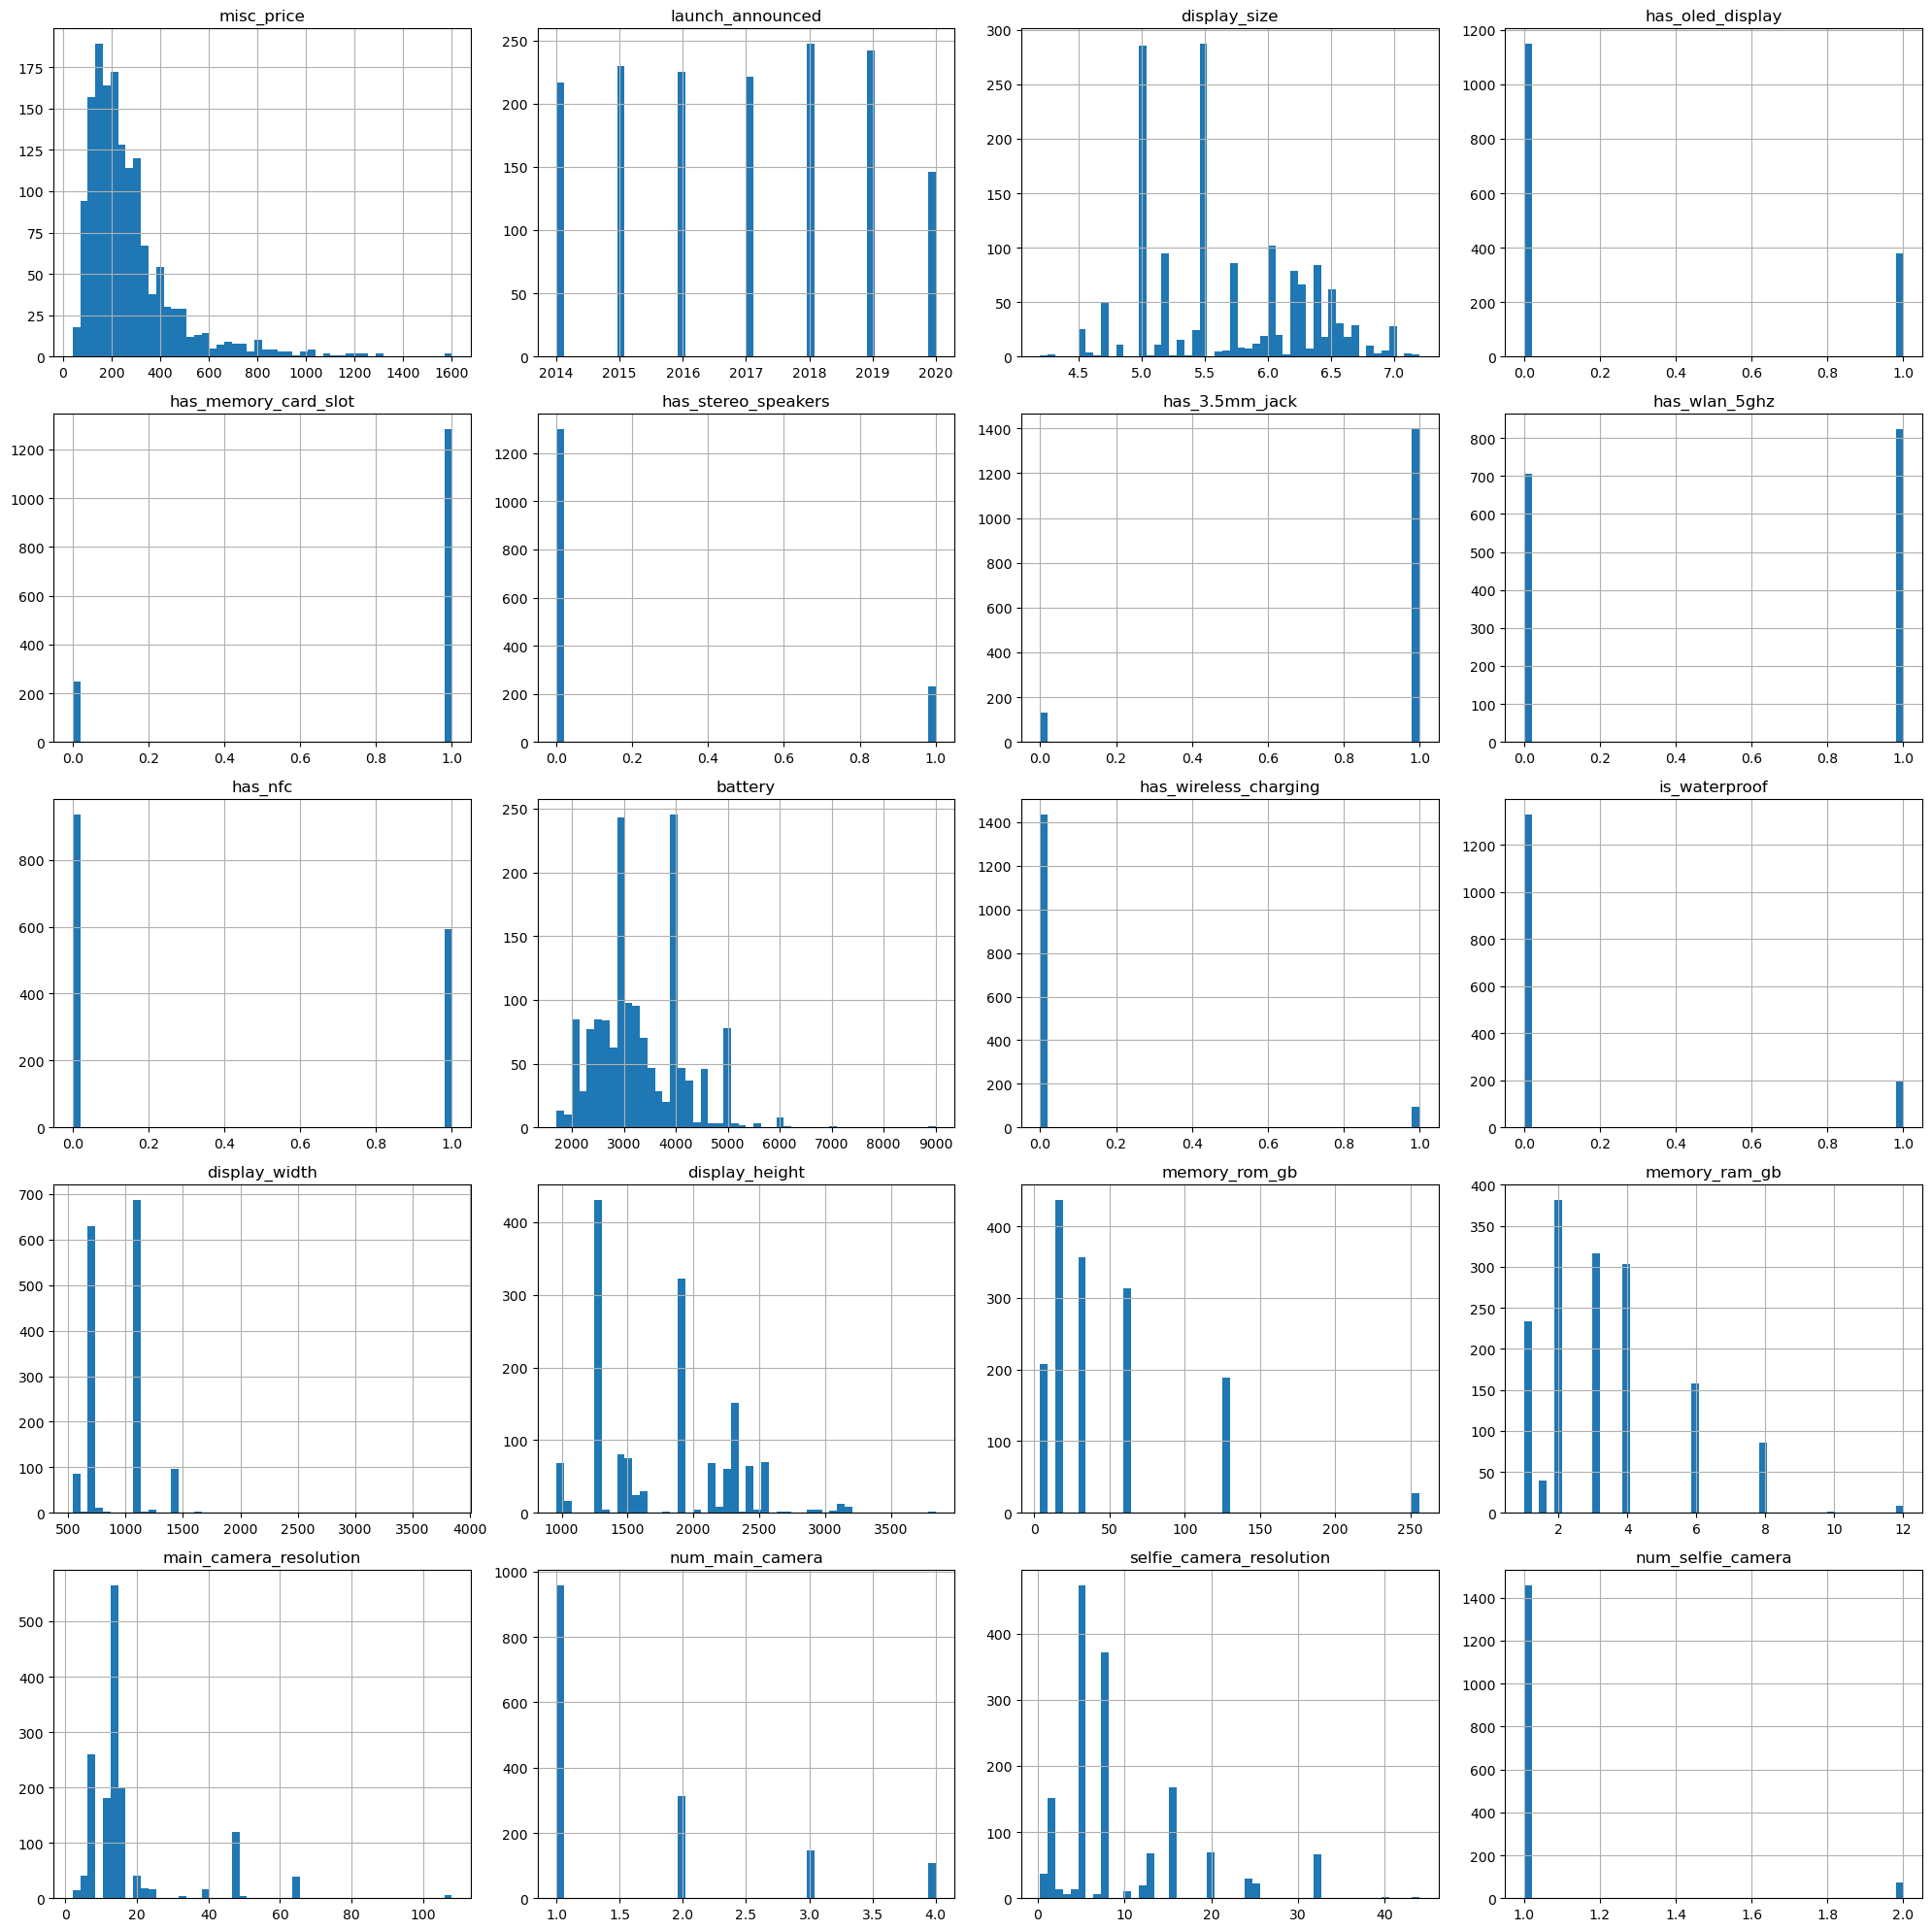

In [94]:
df.hist(figsize=(20, 20), bins=50)
plt.tight_layout()

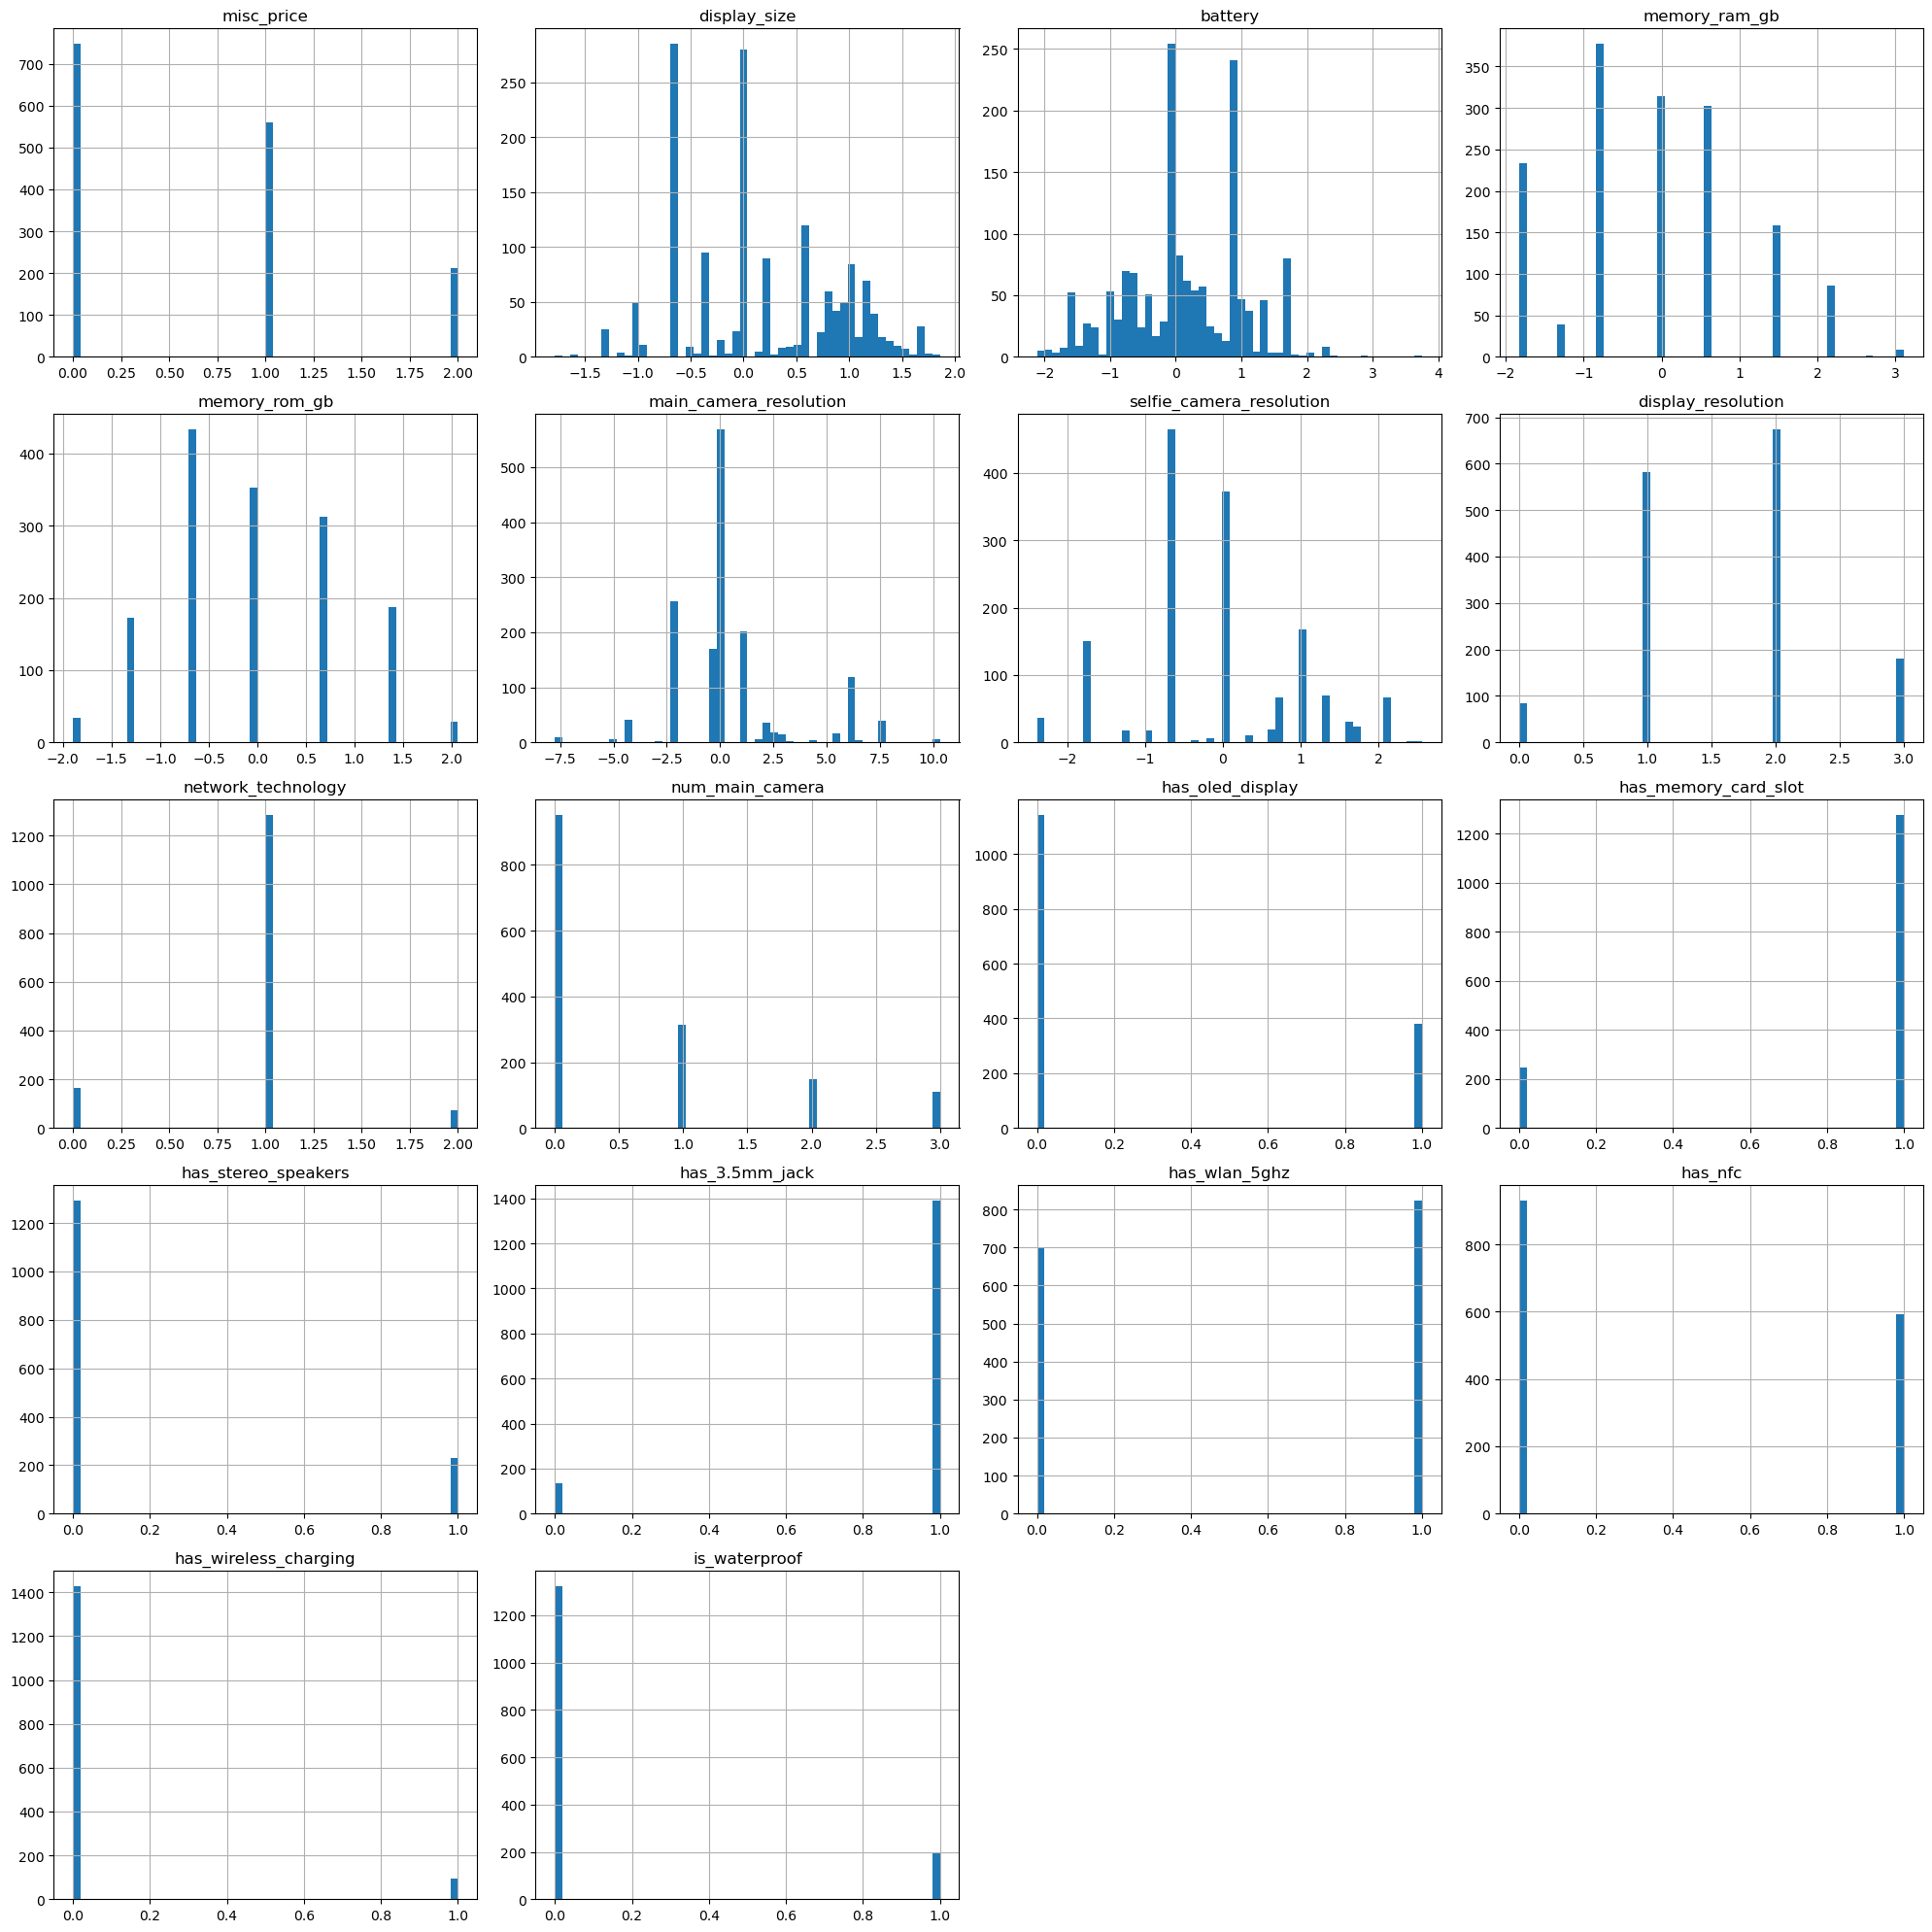

In [95]:
train_preprocess.hist(figsize=(20, 20), bins=50)
plt.tight_layout()

### Standard scaler vs Robust scaler

Display size

TODO

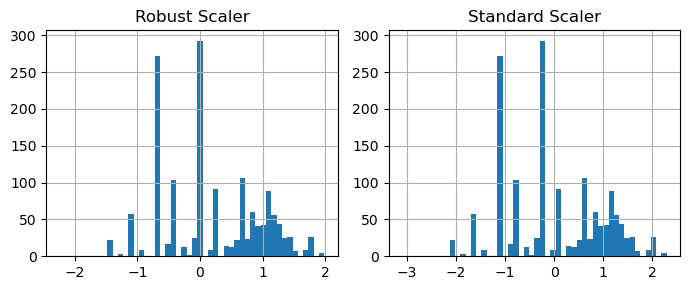

In [46]:
util_data.compare_scalers("display_size", df, train_preprocess, cols_pipeline.transformers_[1][1])
plt.tight_layout()
 

Battery

TODO

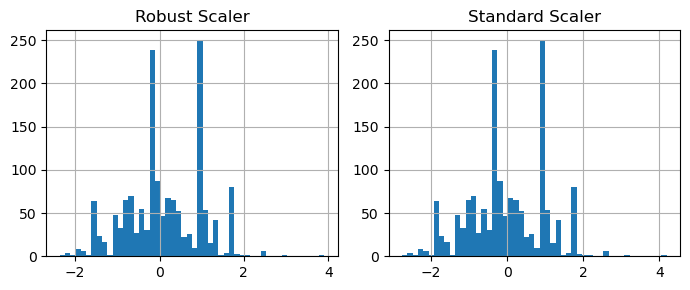

In [47]:
util_data.compare_scalers("battery", df, train_preprocess, cols_pipeline.transformers_[1][1])
plt.tight_layout()


Memory ram

TODO

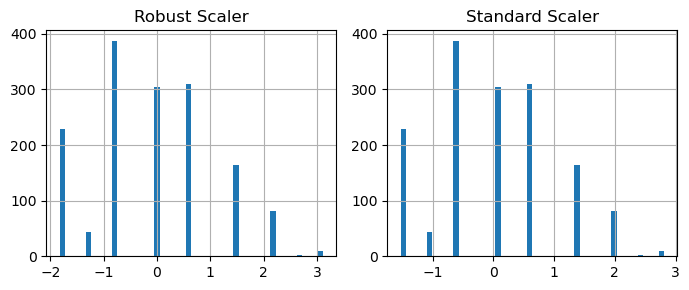

In [48]:
util_data.compare_scalers("memory_ram_gb", df, train_preprocess, cols_pipeline.transformers_[1][1])
plt.tight_layout()

Memory rom

TODO

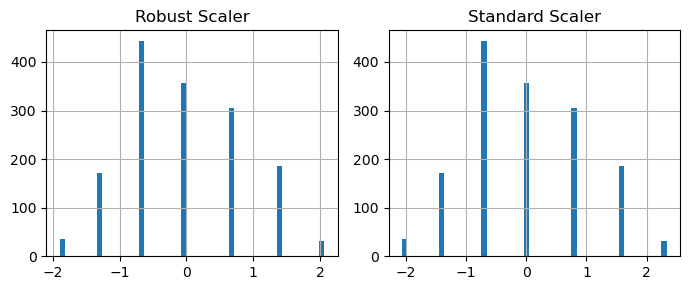

In [49]:
util_data.compare_scalers("memory_rom_gb", df, train_preprocess, cols_pipeline.transformers_[1][1])
plt.tight_layout()

Main camera resolution

TODO

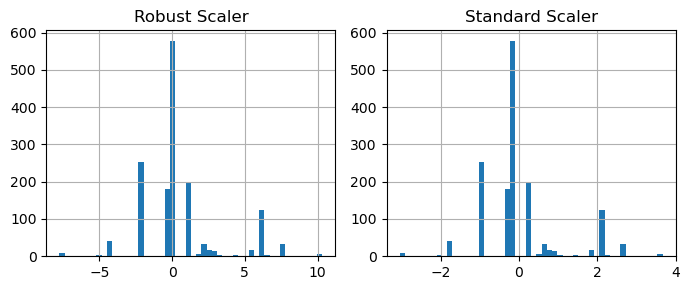

In [51]:
util_data.compare_scalers("main_camera_resolution", df, train_preprocess, cols_pipeline.transformers_[2][1], round=True)
plt.tight_layout()

Selfie camera resolution

TODO

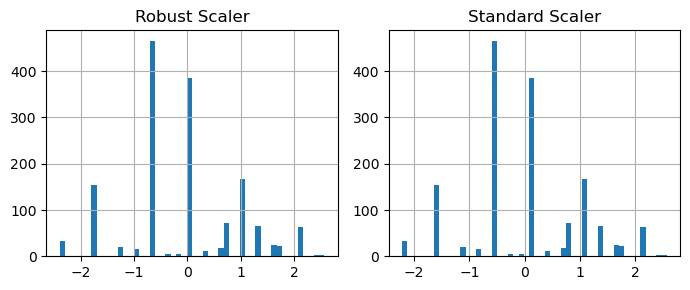

In [53]:
util_data.compare_scalers("selfie_camera_resolution", df, train_preprocess, cols_pipeline.transformers_[2][1], log=True, round=True)
plt.tight_layout()


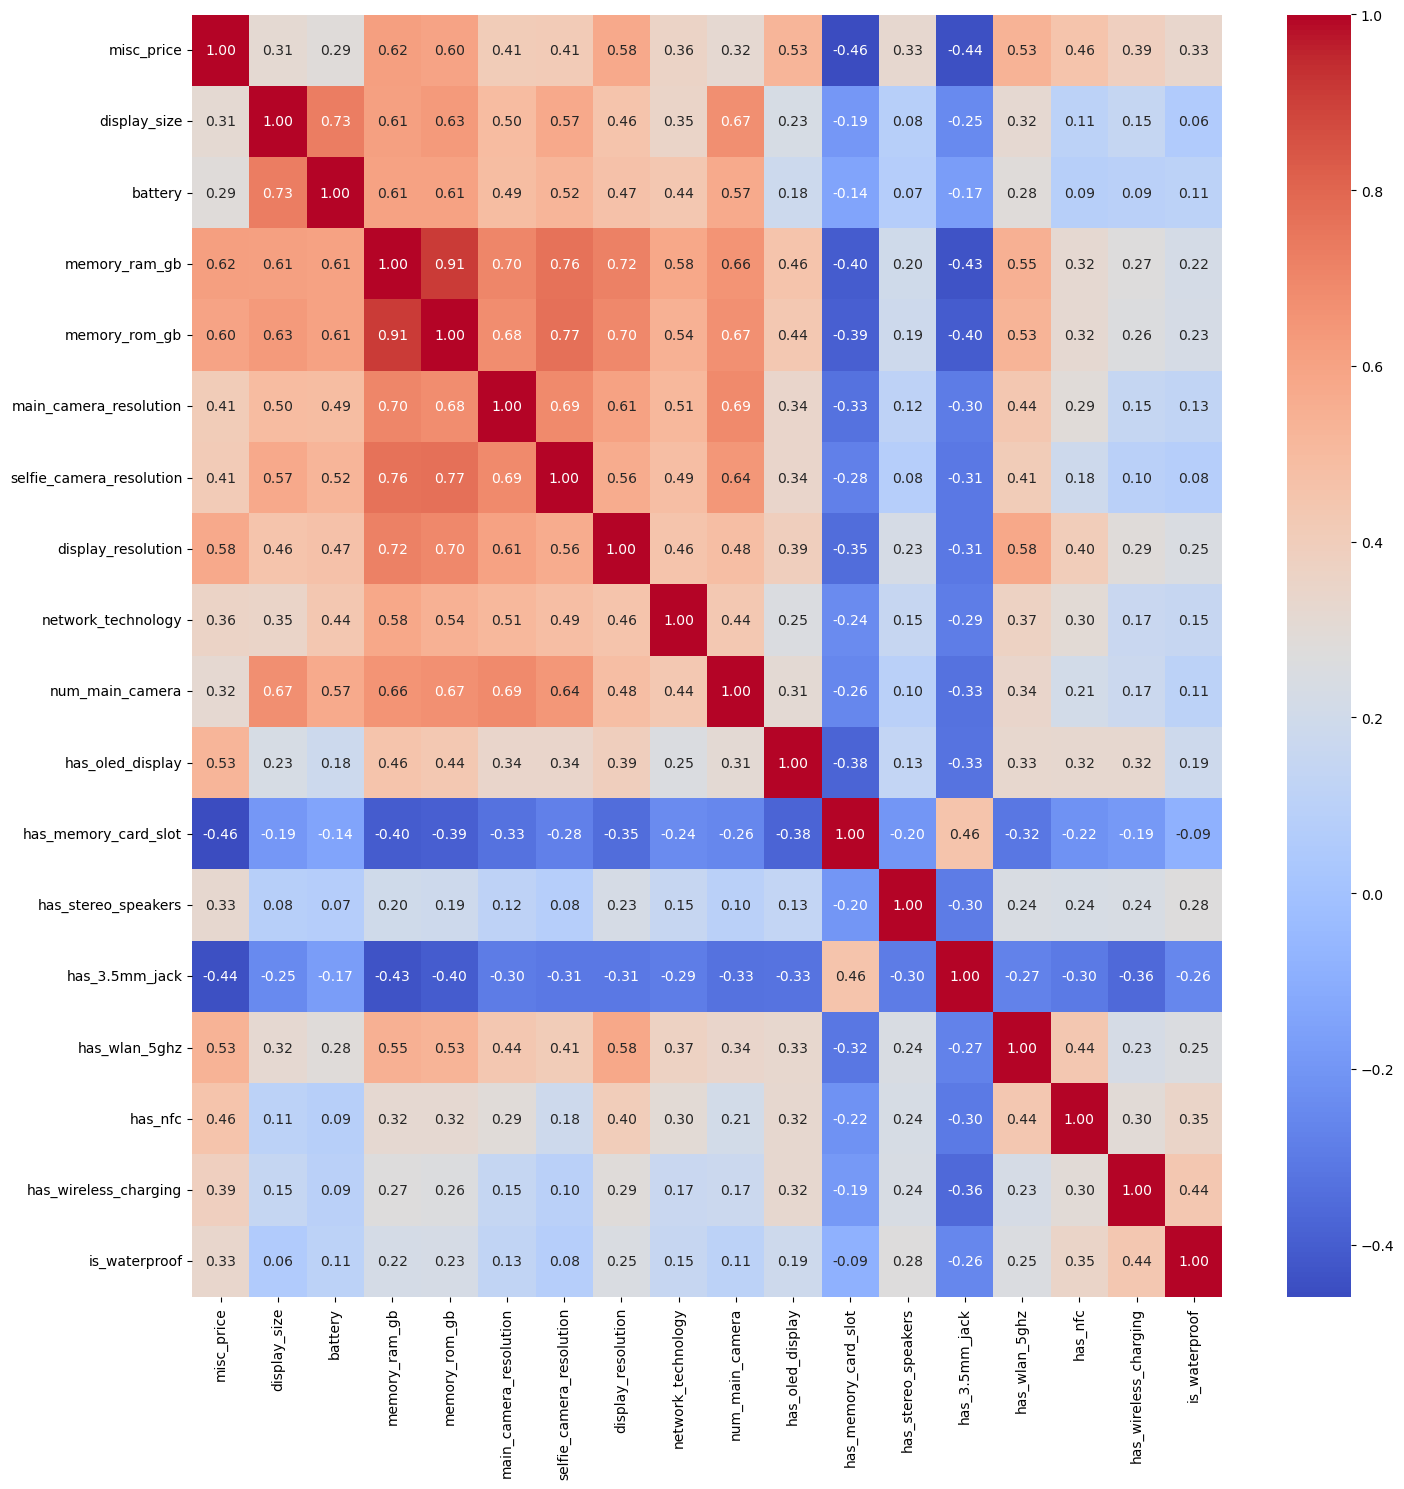

In [96]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_preprocess.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.tight_layout()